In [20]:
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import scipy.interpolate as interp
import scipy.optimize as sciopt
import pickle

In [21]:
# get the cell-count vs od data first

od_path = '../calibration_data/calibration_01312024/EK_single_OD600_20240131_135513.xlsx'
p_od = AutoRate.Plate(od_path,mode='single_measurement')
od_data = p_od.od_data_to_dict(p_od.data)
# background subtract od data

row_list = ['A','B','C','D','E','F','G','H']
bg_cols = [1,11]
bg_cols = [str(c) for c in bg_cols]

bg_est = 0
indx = 0
for row in row_list:
    for col in bg_cols:
        key = row + col
        bg_est += od_data[key]
        indx+=1

bg_est = bg_est/indx

col_list = np.arange(11) + 1
col_list = [str(c) for c in col_list]

od_t = np.zeros((len(row_list)-2,len(col_list)-2))
row_indx = 0
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row+col
        # od_data[key] = od_data[key] - bg_est
        od_t[row_indx,col_indx] = od_data[key] -  bg_est
        col_indx += 1

    row_indx += 1

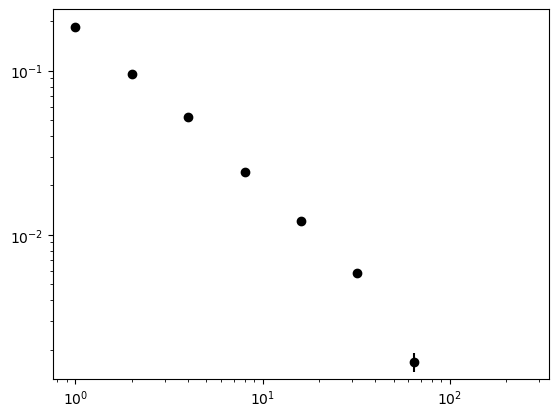

In [22]:
od_avg = np.mean(od_t,axis=0)
od_std = np.std(od_t,axis=0)
od_err = od_std/np.sqrt(len(row_list)-2)

dilutions = []

for i in range(0,len(col_list)-2):
    dilutions.append(2**i)

fig,ax = plt.subplots()

ax.errorbar(dilutions,od_avg,yerr=od_err,fmt='o',color='k')
ax.set_xscale('log')
ax.set_yscale('log')

In [23]:
ab_plate_path = '../calibration_data/calibration_01312024/EK_single_AB_constant_gain_20240131_143115.xlsx'
p_ab = AutoRate.Plate(ab_plate_path,mode='single_measurement')

In [24]:
def od_to_cells(od):
    """Background subtracted od to cell count

    Args:
        od (_type_): _description_

    Returns:
        _type_: _description_
    """
    m = 1
    b = 13.52
    res = []
    for o in od:
        if o < 0:
            res.append(0)
        else:
            res.append(np.exp(m*np.log(o) + b))
    return np.array(res)

cell_count = od_to_cells(od_avg)
cell_count_err = od_to_cells(od_err)

Text(0, 0.5, 'Cell Count (cells/$\\mu$L)')

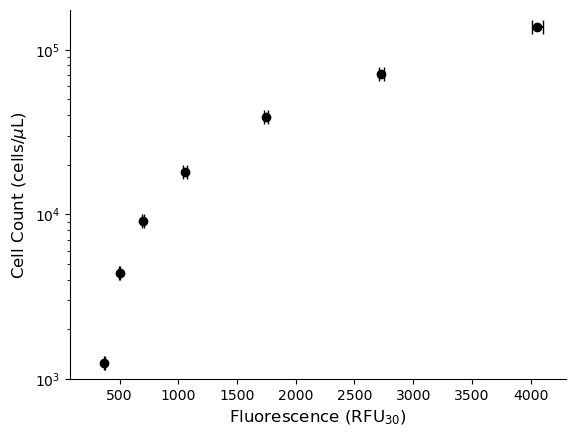

In [25]:
fluor_data = p_ab.od_data_to_dict(p_ab.data)

cmap = mpl.colormaps['viridis']

fluor_data_t = np.zeros((len(row_list)-2,len(col_list)-2))
fluor_data_std = np.zeros((len(row_list)-2,len(col_list)-2))
row_indx = 0
for row in row_list[1:-1]:
    col_indx = 0
    for col in col_list[1:-1]:
        key = row + col
        fluor_data_t[row_indx,col_indx] = fluor_data[key]
        col_indx += 1
    row_indx += 1

fluor_avg = np.mean(fluor_data_t,axis=0)
fluor_err = np.std(fluor_data_t,axis=0)/np.sqrt(len(row_list)-2)

fig,ax = plt.subplots()

ax.errorbar(fluor_avg,cell_count,xerr=fluor_err,fmt='o',capsize=5,color='k')

# ax.set_xscale('log')
ax.set_yscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Fluorescence (RFU$_{30}$)',fontsize=12)
ax.set_ylabel('Cell Count (cells/$\mu$L)',fontsize=12)

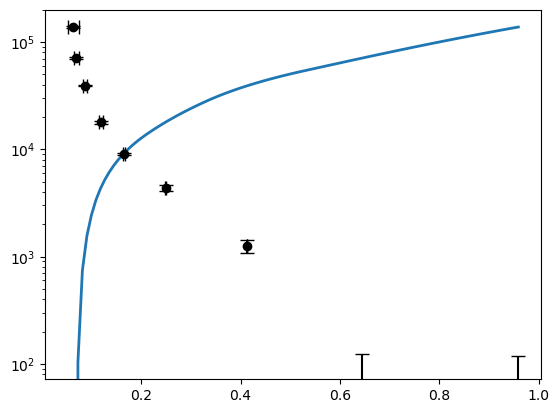

In [36]:
fluor_norm = fluor_data_t/np.max(fluor_data_t)
fluor_norm_avg = np.mean(fluor_norm,axis=0)
fluor_norm_err = np.std(fluor_norm,axis=0)/np.sqrt(len(row_list)-2)

cell_count_norm = cell_count/np.max(cell_count)

s = 0
k = 2

# sort data
sort_indx = np.argsort(fluor_norm_avg)
fluor_norm_avg = fluor_norm_avg[sort_indx]
cell_count_norm = cell_count_norm[sort_indx]

spline = interp.UnivariateSpline(fluor_norm_avg,cell_count_norm,k=k,s=s)
xfit = np.linspace(np.min(fluor_norm_avg),np.max(fluor_norm_avg),100)
yfit = spline(xfit)

fig,ax = plt.subplots()

ax.plot(xfit,yfit*np.max(cell_count),label='spline',linewidth=2)

ax.errorbar(fluor_norm_avg,cell_count,xerr=fluor_norm_err,yerr=cell_count_err,fmt='o',capsize=5,color='k')

ax.set_yscale('log')

In [37]:
pickle.dump(spline,open('spline_cal_01312024.pkl','wb'))

In [39]:
cell_count

array([137928.49126716,  70892.83842128,  39005.94416286,  17896.84496884,
         9091.05153303,   4365.68914001,   1252.65512256,      0.        ,
            0.        ])